ImageNet LSVRC 2012 데이터셋 축소시킨 데이터셋
- torchvision 데이터셋이 아니라
- kaggle 다운

In [ ]:
"""
전이학습을 통한 Classification 문제 해결
전이학습은 기존에 훈련된 모델의 가중치를 가져와서 
모델에 적용시키는 학습 방법
"""

In [1]:
# 모델 사용에 필요한 라이브러리 import
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # matplotlib 대화용 코드

전이학습
- 마지막 출력 계층으로써 주로 선형(Affine; 가중치와 편향에 대한 행렬 연산) 레이어만을 변경하여 
이 변경된 레이어만을 재학습시키는 것
- ref site: http://www.gisdeveloper.co.kr/?p=8655

In [ ]:
# 가중치 초기화를 무작위로 한 후 가중치를 순전파, 역전파를 통해 update 하지만 
# 이 전이학습의 경우는, 기존에 미리 학습되어있는 신경망을 통해 초기화한다
# 초기화된 가중치는 마지막에 연결되어있는 전연결 부분을 제외하고 고정이 되고,
# 마지막 부 전연결 부분은 무작위 가중치를 갖는 새로운 계층으로 대체되어 이 계층만 학습되게 한다.

transforms.Compose 함수
- ref site: https://green-late7.tistory.com/56

In [2]:
# Data augmentaion, normalization(데이터 증가, 일반화)
# 오버피팅 방지하기 위해 일반화 사용
data_transforms  = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean, std
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터를 불러오는 경로를 설정
# 캐글, 깃헙에서 다운받은 데이터 경로
data_dir = './hymenoptera_data' 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}
# 데이터를 불러오는 설정
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# CUDA(GPU 가속화)사용이 가능하게 만드는 설정 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

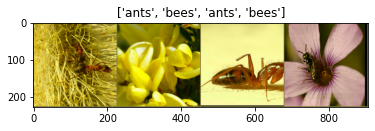

In [3]:
# 사용하게 될 데이터를 시각화하기
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0)) # numpy 변환후 transpose
    mean = np.array([0.485, 0.456, 0.225])
    std = np.array([0.229, 0.224, 0.225]) # 분산
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# 학습 데이터의 배치를 얻는 과정
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 grid를 만드는 과정
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

.eval() 함수는 evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수인 셈
- Dropout Layer
- BatchNorm Layer


d.h. validation 실행시, 위 두 layer에서는 작동하지 않게 해주는 함수
- ref site: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval

state_dict()
- ref site : https://tutorials.pytorch.kr/beginner/saving_loading_models.html
- PyTorch에서 torch.nn.Module 모델의 학습 가능한 매개변수(예. 가중치와 편향)들은 모델의 매개변수에 포함되어 있습니다(model.parameters()로 접근합니다). state_dict 는 간단히 말해 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다. 

optimizer.zero_grad() : gradient를 0으로 초기화
- 파이토치에서는 미분한 값들이 누적되는 특징이 있음
- epoch을 반복하면서 미분한 값들이 누적되기 때문에 초기화
- w -= learinig_rate*w.grad
- ref site : https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EA%B8%B0%EC%B4%88-modelzerograd-optimizerzerograd-%EC%93%B0%EB%8A%94-%EC%9D%B4%EC%9C%A0

In [4]:
# 모델 학습하기

def train_model(model, criterion, optimizer, scheduler, num_epochs = 100):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 # float 형식으로 저장됨
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        
        for phase in ['train', 'val']:# phase에 따라 실행방법이 변경되게 되는데, phase가 train이라면, train을
            if phase == 'train': 
                model.train()
            else: # train이 아닐경우 ('val'을 의미) val으로 실행 (validation)
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # 순전파 과정
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 학습 단계인 경우는 역전파 + 최적화 과정을 거치게 됨
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # learning_rate
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} ACC: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # state_dict(): 전이학습을 시키는 함수
                
            print()
            
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        model.load_state_dict(best_model_wts)
        return model

In [5]:
# 이미지에 대한 예측값을 보여주는 함수
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
            model.train(mode=was_training)

In [7]:
# 신경망 미세조정(fine-tune): 정확도 높일 수 있음
# 가중치를 가져온다고 해서 모델을 가져온다고 할 수 없다. 즉, 현모델에 맞게 미세조정이 필요하다
# in compression(pruning, distilation)

model_ft = models.resnet18(pretrained=True) # 학습이 잘된 resnet 모델과 가중치를 가져옴 # False는 모델구조만 가져옴
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2) # 출력 샘플의 크기는 2로 설정 # inputsize, outputsize

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 매개변수들이 최적화가 잘 되었는지 살펴보기
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 에폭이 7증가 할 때마다 학습률 0.1씩 감소시킴
# exp_lr_scheduler로 바꿀것 *** or exp_lr_scheduler(아래)랑 유의하기 ***
exp_lr_schedular = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
# 학습 진행 및 평가
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_schedular, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.5863 ACC: 0.6885

val Loss: 0.1777 ACC: 0.9216

Training complete in 0s
Best val Acc: 0.921569


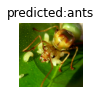

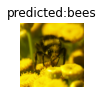

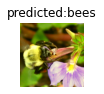

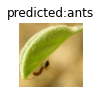

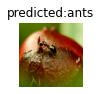

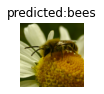

In [9]:
# 예측한 결과를 보여주는 코드
visualize_model(model_ft) 

In [11]:
# 전연결이 되지 않은 부분(마지막 부분)을 제외한 컨벌루션 레이어를 고정시키기 위한 코드
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.6353 ACC: 0.6721

val Loss: 0.2405 ACC: 0.9020

Training complete in 0s
Best val Acc: 0.901961


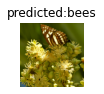

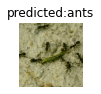

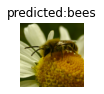

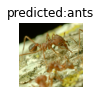

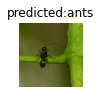

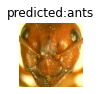

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()